# Group A Programming Assignment 3 Report

**Authors:** Aidnel M Martínez Meléndez, Alex Demel Pacheco, Edgar J Suárez-Colón  
**Course:** ICOM5015-001D Artificial Intelligence

## Task Division

| Task            | Group Member      |
|:-----------------:|:-------------------:|
| Programming     | Alex Demel        |
| Debugging       | Edgar Suarez      |
| Report Writing  | Aidnel Martínez   |
| Report Editing  | Edgar Suarez      |
| Video Scripting | Aidnel Martínez   |
| Video Editing   | Alex Demel        |

## I. Introduction
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this report, we embark on a comprehensive study of searching algorithms through the lens of two distinct challenges: navigating through environments with convex polygonal obstacles and devising strategies for the safe transportation of missionaries and cannibals across a river. Our objective is to study and apply various search algorithms, comparing their performance and aiming to find optimal solutions via computational problem-solving. This exploration is crucial for future computer engineers, as it underscores the significance of algorithmic design, state space optimization, and heuristic strategies in solving complex problems. By delving into these specific scenarios, we not only shed light on the practical applications of searching algorithms but also gain the knowledge and tools necessary to tackle a variety of real-world challenges, from robotics to automated systems, emphasizing the role of efficient algorithmic solutions.

## II. Exercises

#### **Exercise 3.9**
This exercise  aims to find the shortest path between two points on a plane that has convex polygonal obstacles scattered around.

1. If the state space consists of all positions (x, y) in the plane, there is an infinite number of states because every point in the continuous space can be a state. Likewise, there would also be an infinite number of paths to the goal since there are countless ways to navigate around the polygons.

2. In a Euclidean plane, the shortest path between two points is a straight line. However, in a plane with convex polygonal obstacles, a straight-line path may not always be feasible. Under these conditions, the optimal route between any two points is composed of straight-line segments joining some of the vertices of the polygons. This is because any detour into the open space between the edge of a polygon not directly leading to another vertex inevitably elongates the route beyond what is strictly necessary. Thus, the most efficient pathway comprises a sequence of vectors linking the vertices of some obstacles, in addition to the starting and ending vertices. Consequently, the state space can be defined as the set of vertices on the (x, y) plane. It follows that the size of this state space size is directly proportional to the number of vertices present on the plane, which amounts to 35 in **Figure 1**.

3. To effectively tackle this search problem, the following functions and components are essential:

    * A representation of vertices, which will be identified as coordinates on the (x, y) plane.
    * A representation of vectors, representing a straight line connecting two vertices.
    * A representation of polygons, characterized as a sequence of vertices that come together to form a convex figure.
    * A representation of the (x, y) plane, incorporating the starting Vertex, the destination, and the obstacles present.
    * A function accepting a vertex as input and producing a set of vectors, where each vector represents a path to a vertex that can be reached in a straight line without intersecting any polygon edges, considering neighbors on the same polygon.
    * A heuristic function aimed at estimating the straight-line distance between any pair of vertices, serving to guide the search process.

    **These functions and components will be implemented below:**
    
    **Note**: The Shapely library [1] was used to represent vertices, vectors, and polygons. This was necessary to efficiently calculate intersections between straight-line paths and the polygonal obstacles in the (x, y) plane.


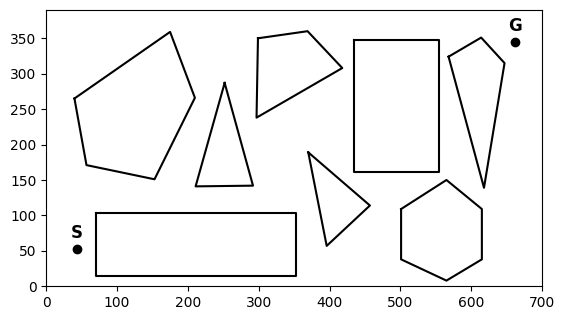

**Figure 1:** *The XY Plane with the polygonal obstacles, start, and goal*

In [78]:
import matplotlib.pyplot as plt
from shapely.geometry import Point as Vertex, LineString as Vector, Polygon
from IPython.display import display_markdown
import math

class XYPlaneProblem:
    def __init__(self, width, height, start=None, goal=None):
        self.width = width
        self.height = height
        self.polygons = []
        self.paths = []
        self.start = Vertex(start) if start else None
        self.goal = Vertex(goal) if goal else None

    def add_polygon(self, polygon):
        self.polygons.append(Polygon(polygon))

    def intersects_polygon(self, line):
        intersections = [line.intersection(polygon) for polygon in self.polygons if line.intersects(polygon)]
        return intersections

    def display(self):
        fig, ax = plt.subplots()
        for polygon in self.polygons:
            x, y = polygon.exterior.xy
            ax.plot(x, y, 'k-')

        if self.start:
            ax.plot(self.start.x, self.start.y, 'ko')
            ax.text(self.start.x, self.start.y + 15, 'S', color='black', fontsize=12, fontweight='bold', ha='center')

        if self.goal:
            ax.plot(self.goal.x, self.goal.y, 'ko')
            ax.text(self.goal.x, self.goal.y + 15, 'G', color='black', fontsize=12, fontweight='bold', ha='center')

        for line in self.paths:
            x, y = line.xy
            dx = x[1] - x[0]
            dy = y[1] - y[0]
            distance = math.hypot(dx, dy)
            if distance == 0:
                continue
            
            scale_factor = (distance - 14) / distance
            dx *= scale_factor
            dy *= scale_factor
            
            ax.arrow(x[0], y[0], dx, dy, head_width=8, head_length=14, fc='green', ec='green', linewidth=2)

        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

def heuristic(point1, point2):
    return point1.distance(point2)

def reachable_vectors(xyplane, start):
    reachable_vectors = []

    def is_on_polygon(point, polygons):
        for polygon in polygons:
            if polygon.contains(point) or polygon.boundary.contains(point):
                return True, polygon
        return False, None

    def is_valid_intersection(intersections, path_start, path_end):
        if not intersections:
            return True
        for intersection in intersections:
            if not (intersection.equals(path_start) or intersection.equals(path_end)):
                return False
        return True

    def path_is_polygon_edge(path, polygon):
        for i in range(len(polygon.exterior.coords) - 1):
            edge = Vector([polygon.exterior.coords[i], polygon.exterior.coords[i + 1]])
            if edge.contains(path):
                return True
        return False

    on_polygon, polygon = is_on_polygon(start, xyplane.polygons)
    if on_polygon:
        for vertex in polygon.exterior.coords[:-1]:
            vertex_point = Vertex(vertex)
            path = Vector([start, vertex_point])
            if path_is_polygon_edge(path, polygon):
                if vertex_point.distance(xyplane.goal) < start.distance(xyplane.goal):
                    reachable_vectors.append(path)

    for polygon in xyplane.polygons:
        for vertex in polygon.exterior.coords[:-1]:
            path = Vector([start, Vertex(vertex)])
            path_start = Vertex(path.coords[0])
            path_end = Vertex(path.coords[-1])
            intersections = [path.intersection(p) for p in xyplane.polygons if path.intersects(p)]

            valid_intersections = is_valid_intersection(intersections, path_start, path_end)
            
            if (path_is_polygon_edge(path, polygon) or valid_intersections) and not any(path.equals(vector) for vector in reachable_vectors):
                if path.length > 0: reachable_vectors.append(path)

    path_to_goal = Vector([start, xyplane.goal])
    intersections = xyplane.intersects_polygon(path_to_goal)

    if is_valid_intersection(intersections, start, xyplane.goal):
        if path_to_goal.length > 0: reachable_vectors.append(path_to_goal)
    else:
        if start in intersections: intersections.remove(start)
        nearest_intersection_point = None
        min_distance = float('inf')
        for intersection in intersections:
            if isinstance(intersection, Vertex):
                distance = start.distance(intersection)
                if distance < min_distance and not intersection.equals(xyplane.goal):
                    nearest_intersection_point = intersection
                    min_distance = distance
            elif isinstance(intersection, Vector):
                for point in intersection.coords:
                    point = Vertex(point)
                    distance = start.distance(point)
                    if distance < min_distance and not point.equals(xyplane.goal):
                        nearest_intersection_point = point
                        min_distance = distance

        if nearest_intersection_point is not None:
            path_to_nearest_intersection = Vector([start, nearest_intersection_point])
            if path_to_nearest_intersection.length > 0:
                reachable_vectors.append(path_to_nearest_intersection)

    return reachable_vectors

start, goal = Vertex(43, 53), Vertex(662, 345)
xyplane = XYPlaneProblem(700, 390, start, goal)

xyplane.add_polygon([(40, 265), (175, 359), (210, 266), (153, 151), (57, 171)])
xyplane.add_polygon([(70, 103), (353, 103), (353, 14), (70, 14)])
xyplane.add_polygon([(252, 287), (292, 142), (211, 141)])
xyplane.add_polygon([(299, 350), (369, 360), (418, 308), (297, 238)])
xyplane.add_polygon([(370, 189), (457, 114), (396, 57)])
xyplane.add_polygon([(434, 348), (554, 348), (554, 161), (434, 161)])
xyplane.add_polygon([(568, 324), (614, 351), (647, 315), (618, 139)])
xyplane.add_polygon([(501, 109), (565, 150), (615, 109), (615, 38), (565, 8), (501, 38)])

xyplane.display()
display_markdown('**Figure 1:** *The XY Plane with the polygonal obstacles, start, and goal*', raw=True)


4. To address the search problem outlined previously, we will employ a range of search algorithms discussed in Norvig and Russell's Artificial Intelligence textbook [2], in conjunction with UC Berkeley's code repository [3] dedicated to the textbook. These algorithms will be compared and evaluated based on their performance.

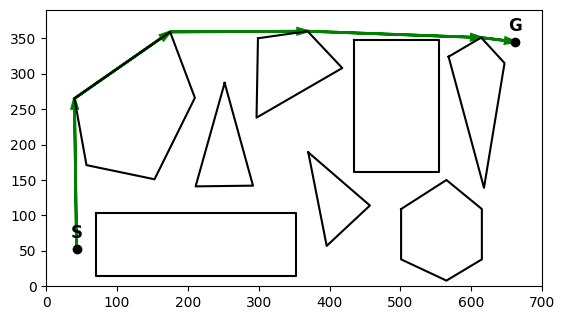

**Figure 2:** *The path found by Greedy-Best-First Search*

Total distance: 864.0648791567446


In [79]:
from queue import PriorityQueue

class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
    
    def __lt__(self, other):
        return self.path_cost < other.path_cost

def greedy_best_first_search(problem, heuristic):

    start = problem.start
    goal = problem.goal

    start_node = Node(start)
    frontier = PriorityQueue()
    frontier.put((0, start_node))
    reached = {start: start_node}

    while not frontier.empty():
        current_node = frontier.get()[1]
        current_state = current_node.state
        
        if current_state.equals(goal):
            return current_node
        
        for vector in reachable_vectors(problem, current_state):
            child_state = Vertex(vector.coords[1])
            action = vector
            path_cost = heuristic(child_state, problem.goal)
            child_node = Node(child_state, current_node, action, path_cost)
            
            if child_state not in reached or child_node.path_cost < reached[child_state].path_cost:
                reached[child_state] = child_node
                frontier.put((path_cost, child_node))
                
    return None

def reconstruct_path(node):
    path = []
    while node.parent is not None:
        path.append(node.action)
        node = node.parent
    path.reverse()
    return path

xyplane.paths = []
solution = greedy_best_first_search(xyplane, heuristic)
path = reconstruct_path(solution)

total_distance = 0
for vector in path:
    total_distance += vector.length
    xyplane.paths.append(vector)

xyplane.display()
display_markdown('**Figure 2:** *The path found by Greedy-Best-First Search*', raw=True)
print("Total distance: {}".format(total_distance))


**Figure 2** illustrates the path determined by the Greedy-Best-First Search algorithm, achieving a total distance of 864 units. However, it's critical to understand that this algorithm prioritizes the exploration of nodes with the lowest heuristic value, essentially, those nodes that seem nearest to the goal on a superficial level. This method can expedite finding a solution by focusing on immediate proximity to the goal, yet such a strategy might not always yield the most efficient or shortest path available.

Next, we will assess the A* search algorithm's performance:

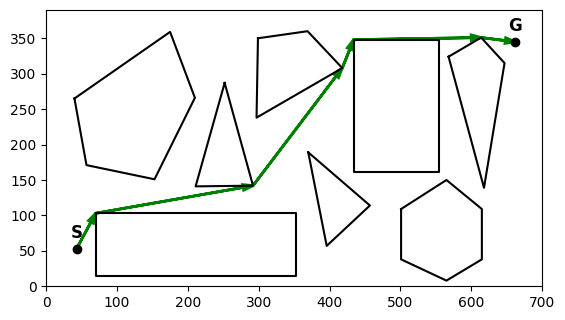

**Figure 3:** *The path found by A\* Search*

Total distance: 762.1072537326372


In [80]:
def astar_search(problem, heuristic):

    start = problem.start
    goal = problem.goal

    start_node = Node(start)
    frontier = PriorityQueue()
    frontier.put((0 + heuristic(start, goal), start_node))
    reached = {start: start_node}

    while not frontier.empty():
        current_node = frontier.get()[1]
        current_state = current_node.state
        
        if current_state.equals(goal):
            return current_node
        
        for vector in reachable_vectors(problem, current_state):
            child_state = Vertex(vector.coords[1])
            action = vector
            path_cost = current_node.path_cost + vector.length
            child_node = Node(child_state, current_node, action, path_cost)
            
            if child_state not in reached or path_cost + heuristic(child_state, goal) < reached[child_state].path_cost + heuristic(reached[child_state].state, goal):
                reached[child_state] = child_node
                priority = path_cost + heuristic(child_state, goal)
                frontier.put((priority, child_node))
                
    return None

def reconstruct_path(node):
    path = []
    while node.parent is not None:
        path.append(node.action)
        node = node.parent
    path.reverse()
    return path

xyplane.paths = []
solution = astar_search(xyplane, heuristic)
path = reconstruct_path(solution)

total_distance = 0
for vector in path:
    total_distance += vector.length
    xyplane.paths.append(vector)

xyplane.display()
display_markdown('**Figure 3:** *The path found by A\* Search*', raw=True)
print("Total distance: {}".format(total_distance))

**Figure 3** presents the route determined by the A* search algorithm, covering a total distance of 762 units and saving 102 units over Greedy-Best-First Search. The improved performance of A* search is attributed to its evaluation function. Unlike Greedy-Best-First Search, A* search evaluates both the cumulative cost of reaching a node from the initial state and the estimated cost of the shortest path from that node to the goal state. This dual consideration guides the search towards the shortest path to the goal, and the optimal solution for the given search problem.

---

#### **Exercise 3.11**
This exercise aims to develop a strategy for safely transporting three missionaries and three cannibals across a river using a two-passenger boat. The challenge lies in ensuring that the missionaries are never outnumbered by the cannibals at any point during the transportation.

1. This problem can be conceptualized as a tuple containing three elements (M, C, B), where:
    - M denotes the number of missionaries on the original side of the river
    - C signifies the number of cannibals on the same side
    - B represents the position of the boat, encoded as a binary value (1 for the boat being on the original side, and 0 for it being on the opposite bank).

    The initial configuration is described by the tuple (3, 3, 1), which indicates that all three missionaries, all three cannibals, and the boat are positioned on the original side of the river. The objective is to transition to the goal state of (0, 0, 0), signifying that all missionaries, cannibals, and the boat have been successfully transported to the river's opposite bank.

    The allowed actions for this problem involve transporting 'n' missionaries and 'm' cannibals from one bank to the other, with the constraint that 0 < n + m <= 2. This stipulation ensures that the boat is neither empty during transit nor exceeds its capacity of two individuals. Furthermore, to maintain the safety of the missionaries, the condition M >= C must be upheld at all times to prevent the cannibals from outnumbering the missionaries.

    A representation of the problem, alongside an illustration of its state space will be provided below to better visualize the problem at hand:

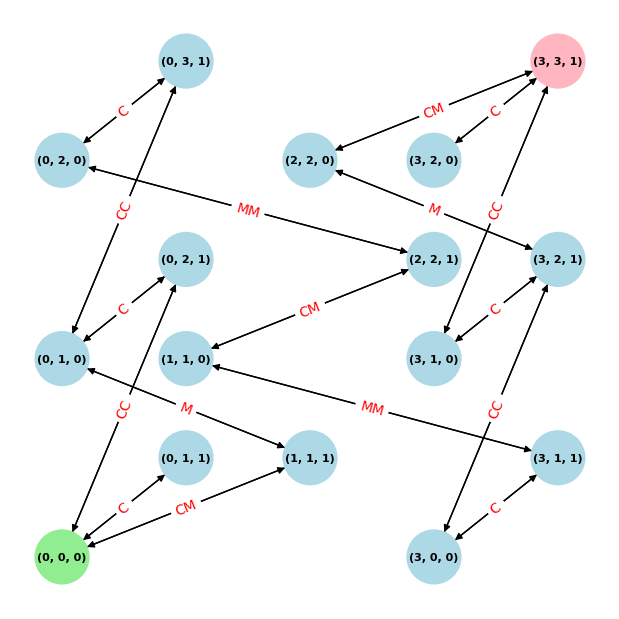

**Figure 4:** *The complete state space for the Missionaries Problem*

In [81]:
import networkx as nx

class MissionariesProblem:
    def __init__(self, initial_state, goal_state):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.G = nx.DiGraph()
        self._build()

    def _successors(self, node):
        directions = [1, -1]
        actions = [(0, 1), (1, 0), (1, 1), (2, 0), (0, 2)]
        result = []
        state = node.state
        M, C, B = state

        for direction in directions:
            for m, c in actions:
                newB = B - direction
                if newB not in {0, 1}:
                    continue

                newM = M - (m * direction)
                newC = C - (c * direction)

                otherM = 3 - newM
                otherC = 3 - newC

                if 0 <= newM <= 3 and 0 <= newC <= 3 and \
                   0 <= otherM <= 3 and 0 <= otherC <= 3 and \
                   (newM == 0 or newM >= newC) and (otherM == 0 or otherM >= otherC):
                    next_state = (newM, newC, newB)
                    result.append(Node(next_state, node, (m, c), node.path_cost + 1))

        return result

    def _goal_test(self, state):
        return state == self.goal_state

    def _build(self):
        initial_node = Node(self.initial_state)
        queue = [initial_node]
        self.G.add_node(initial_node.state)
        action_labels = {(1, 0): 'M', (2, 0): 'MM', (0, 1): 'C', (0, 2): 'CC', (1, 1): 'CM'}

        while queue:
            current_node = queue.pop(0)
            current_state = current_node.state

            for next_node in self._successors(current_node):
                next_state = next_node.state
                self.G.add_node(next_state)

                m_diff = abs(current_state[0] - next_state[0])
                c_diff = abs(current_state[1] - next_state[1])
                action = action_labels.get((m_diff, c_diff), '')

                if (current_state, next_state) not in self.G.edges:
                    queue.append(next_node)
                    self.G.add_edge(current_state, next_state, action=action)

    def display(self):
        pos = {}
        node_color = []
        for node in self.G.nodes():
            M, C, B = node
            if B == 0:
                pos[node] = (M, C)
            else:
                pos[node] = (M + 1, C - 0.5)

            if node == self.initial_state:
                node_color.append('lightpink')
            elif node == self.goal_state:
                node_color.append('lightgreen')
            else:
                node_color.append('lightblue')

        plt.figure(figsize=(6, 6))
        edge_labels = nx.get_edge_attributes(self.G, 'action')
        nx.draw(self.G, pos, with_labels=True, node_size=1500, node_color=node_color, font_size=8, font_weight="bold")
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels, font_color='red')
        plt.show()

problem = MissionariesProblem((3, 3, 1), (0, 0, 0))
problem.display()
display_markdown('**Figure 4:** *The complete state space for the Missionaries Problem*', raw=True)


**Figure 4** provides a comprehensive visualization of the entire state space for the Missionaries and Cannibals problem. Each node within this space is represented by a tuple (M, C, B), indicating the number of missionaries, cannibals, and the current location of the boat, respectively. The connections or edges between each node symbolize the specific actions taken to transition from one state to another. These actions are denoted by (M, MM, MC, CC), where 'M' signifies a single missionary crossing the river, 'MM' denotes two missionaries traveling together, 'MC' indicates a missionary and a cannibal crossing together, and 'CC' represents two cannibals making the journey. This structure efficiently encapsulates the potential movements and decisions within the problem, facilitating a clearer understanding of its dynamics.

2. Given the relatively small state space of the problem, identifying a solution is straightforward for any optimal algorithm, and can even be achieved through manual inspection. Apart from the initial and final states, each intermediate state only allows a single valid action. Thus, by tracking the states that have been reached, we can efficiently reach the objective while ensuring we do not revisit any previously encountered states. To illustrate this approach, we will employ uniform-cost search to find the solution, where each action taken will have a cost of 1.

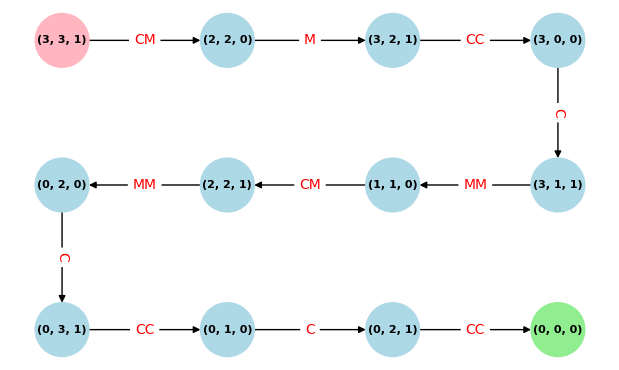

**Figure 5:** *The solution found by Uniform Cost Search*

In [82]:
def uniform_cost_search(problem):
    node = Node(problem.initial_state)
    frontier = PriorityQueue()
    frontier.put((0, node))
    reached = {problem.initial_state: node}

    while not frontier.empty():
        _, current_node = frontier.get()
        current_state = current_node.state

        if current_state == problem.goal_state:
            return current_node

        for child in problem._successors(current_node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.put((child.path_cost, child))

    return None

def display_solution(solution_node):
    G = nx.DiGraph()
    action_labels = {(1, 0): 'M', (2, 0): 'MM', (0, 1): 'C', (0, 2): 'CC', (1, 1): 'CM'}

    path = []
    while solution_node is not None:
        path.append(solution_node)
        solution_node = solution_node.parent
    path.reverse()

    pos = {}
    node_color = []
    x, y = 0, 0
    direction = 1
    for i, node in enumerate(path):
        pos[node.state] = (x, y)
        G.add_node(node.state)
        
        if i > 0:
            prev_node = path[i - 1]
            action = action_labels.get((abs(prev_node.state[0] - node.state[0]), abs(prev_node.state[1] - node.state[1])), '')
            G.add_edge(prev_node.state, node.state, action=action)
        
        if i % 4 == 3:
            y -= 1
            direction *= -1
        else:
            x += direction
        
        if node.state == problem.initial_state:
            node_color.append('lightpink')
        elif node.state == problem.goal_state:
            node_color.append('lightgreen')
        else:
            node_color.append('lightblue')

    plt.figure(figsize=(6, 3.5))
    edge_labels = nx.get_edge_attributes(G, 'action')
    nx.draw(G, pos, with_labels=True, node_size=1500, node_color=node_color, font_size=8, font_weight="bold", arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.show()

solution = uniform_cost_search(problem)
display_solution(solution)
display_markdown('**Figure 5:** *The solution found by Uniform Cost Search*', raw=True)

**Figure 5** illustrates the solution derived through the Uniform Cost Search algorithm, outlining the specific actions executed at each state to progress to the subsequent one, culminating in the attainment of the goal state.

3. Despite the problem's state space appearing straightforward, people may have a difficult time obtaining the solution. This is because the task of manually navigating through the myriad of invalid combinations at each state to identify the sole valid state transformation that brings the search closer to the goal while avoiding any regression to previously visited states is not trivial.

## III. Analysis

| Algorithm               | Total Distance (units) | Notes                                          |
|-------------------------|------------------------|------------------------------------------------|
| Greedy-Best-First Search| 864                    | Prioritizes nodes that appear closest to goal  |
| A* Search               | 762                    | Considers both path cost and heuristic to goal |

*Table 1: Search algorithm performance for exercise 3.9*

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Exercise 3.9**, aimed to find the shortest route between two points in a (x, y) plane with convex polygonal obstacles presented in **Figure 1**. To accomplish this, we utilized the informed search strategies of Greedy-Best-First Search and A* Search, with their resultant paths showcased in **Figures 2 & 3**, respectively, and their performance metrics detailed in **Table 1**. The Greedy algorithm, by prioritizing the nodes closest to the goal based on heuristic value, traversed a distance of 864 units. Conversely, the A* Search algorithm, by evaluating both the accumulated cost to reach a node and the heuristic estimate from that node to the goal, markedly surpassed the Greedy algorithm, covering a reduced distance of 762 units. This highlights the enhanced pathfinding prowess of A* Search, driven by its dual-criterion evaluation function, which not only identifies but secures the most efficient and shortest possible path, thereby offering an optimal solution to the search problem.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Exercise 3.11** focused on strategizing the safe transportation of three missionaries and three cannibals across a river using a boat that holds two passengers. This scenario was modeled using a tuple notation (M, C, B), where M denoted the number of missionaries, C the number of cannibals, and B the boat's position. Through establishing specific restrictions on the tuple values, we effectively mapped out the entire state space of the problem, as illustrated in **Figure 4**, revealing it to be deceptively simple and solvable via any optimal search algorithm. Nevertheless, manually solving the problem without a search algorithm or a map of the state space is far from easy. The genuine difficulty lies in painstakingly eliminating numerous invalid combinations at each state, in order to identify the only feasible action that enables progress toward the goal. **Figure 5** showcases the solution to the problem through the application of the Uniform Cost Search algorithm, delineating the precise sequence of actions required at each state to transition successfully to the next, ultimately reaching the goal state.

## VI. Conclusion

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The study of search algorithms plays a pivotal role in the realm of computing, as they are integral to efficiently tackling complex computational problems. Our project underscores their importance by delving into two specific challenges: navigating through environments with obstacles and devising strategies for safely transporting missionaries and cannibals across a river. Through these exercises, we not only applied various search algorithms but also evaluated their performance and ability to find optimal solutions.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the navigation challenge, our analysis demonstrated the superiority of the A* Search algorithm in pathfinding. Unlike the Greedy-Best-First Search, which considers only the heuristic estimates, the A* algorithm takes into account both the heuristic estimates and the cumulative path cost to a node. This dual consideration significantly improves its performance and allows it to achieve an optimal solution. For the transportation challenge, we discovered the power of reducing a problem to its fundamental components to decrease its complexity. This approach allowed us to thoroughly map the problem’s entire state space, thereby streamlining the process of finding a solution. By applying the uniform-cost search algorithm in this simplified context, we were able to directly identify the optimal solution. This strategy of strategic abstraction not only facilitated the problem-solving process but also highlighted how simplifying complex scenarios can reveal direct solutions.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Our exploration reaffirms the indispensable role that search algorithms play across a wide range of applications. As technology advances, proficiency in these algorithms becomes crucial for future computer engineers, underpinning innovation and problem-solving in the rapidly evolving tech landscape.

# References

1. A. Shavit et al., “Shapely: manipulation and analysis of geometric objects,” Shapely 2.0.3 documentation. toblerity.org, 2007 [Online] Available: https://shapely.readthedocs.io/en/stable/
2. S. J. Russell and P. Norvig, Artificial Intelligence: A Modern Approach. Upper Saddle River: Prentice-Hall, 2010. 
3. Aimacode. Aimacode/aima-python: Python implementation of algorithms from Russell and Norvig’s “artificial intelligence - A modern approach.” GitHub. [Online] Available: https://github.com/aimacode/aima-python
